In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ywwbw79k
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ywwbw79k
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4289 sha256=1aa6c5dac522ad15efd8266154f91d0adf74ad4ed6b956f6cc6014fa555e04eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ljj3nr53/wheels/db/c1/1f/a2bb07bbb4a1ce3c43921252aeafaa6205f08637e292496f04
Successfully built NVCCPlugin


In [3]:
%load_ext nvcc_plugin

directory /notebooks/BilinearInterpolation/src already exists
Out bin /notebooks/BilinearInterpolation/result.out


In [5]:
%%cu
#include "/notebooks/BilateralFiltering/EasyBMP.h"
#include "/notebooks/BilateralFiltering/EasyBMP_BMP.h"
#include "/notebooks/BilateralFiltering/EasyBMP_DataStructures.h"
#include "/notebooks/BilateralFiltering/EasyBMP_VariousBMPutilities.h"
#include "/notebooks/BilateralFiltering/EasyBMP.cpp"
#include <iostream>
#include <cuda_runtime.h>
#include <ctime>

#include <string>
#include <iomanip>
#include <chrono>

using namespace std;
using namespace std::chrono;

texture<float, cudaTextureType2D, cudaReadModeElementType> texRef;

void saveImage(float* image, int height, int width, bool method) {
    BMP Output;
    Output.SetSize(width, height);

    for (int i = 0; i < height; i++) {
        for (int j = 0; j < width; j++) {
            RGBApixel pixel;
            pixel.Red = image[i * width + j];
            pixel.Green = image[i * width + j];
            pixel.Blue = image[i * width + j];
            Output.SetPixel(j, i, pixel);
        }
    }
    if (method)
        Output.WriteToFile("/notebooks/BilinearInterpolation/outputGPU.bmp");
    else
        Output.WriteToFile("/notebooks/BilinearInterpolation/outputCPU.bmp");
}

void filterCPU(float* image, float* resault, int height, int width)
{
    for (int j = 0; j < height-1; j++) {
        for (int i = 0; i < width-1; i++) {

            float f01 = image[j * width + i];
            float f11 = image[j * width + i + 1];
            float f00 = image[j * width + width + i];
            float f10 = image[j * width + width + i + 1];

            float n11 = f01 * 0.5 + f11 * 0.5;
            float n00 = f00 * 0.5 + f01 * 0.5;
            float n10 = f00 * 0.5 * 0.5 + f10 * 0.5 * 0.5 + f01 * 0.5 * 0.5 + f11 * 0.5 * 0.5;

            resault[j* width * 4 + i * 2] = f01;
            resault[j * width * 4 + i * 2 + 1] = n11;
            resault[j * width * 4 + i * 2 + width * 2] = n00;
            resault[j * width * 4 + i * 2 + width * 2 + 1] = n10;
        }
    }
}

__global__ void filterGPU(float* output, int imageWidth, int imageHeight) {

    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    float f01 = tex2D(texRef, col, row);
    float f11 = tex2D(texRef, col+1, row);
    float f00 = tex2D(texRef, col, row+1);
    float f10 = tex2D(texRef, col + 1, row+1);

    float n11 = f01*0.5+f11*0.5;
    float n00 = f00*0.5+f01*0.5;
    float n10 = f00 * 0.5 * 0.5 + f10 * 0.5*0.5 + f01 * 0.5 * 0.5 + f11 * 0.5 * 0.5;

    output[row * imageWidth * 4 + col*2] = f01;
    output[row * imageWidth * 4 + col * 2 + 1] = n11;
    output[row * imageWidth * 4 + col * 2 + imageWidth * 2] = n00;
    output[row * imageWidth * 4 + col * 2 + imageWidth * 2 + 1] = n10;
}

void transformImageCPU(float* image, float* output, int height, int width, int iterations) {
    for (int j = 0; j < iterations; j++) {
        filterCPU(image, output, height, width);
    }
}

void transformImageGPU(float* image, float* output, float* outputDevice, int height, int width, int iterations) {

    cudaChannelFormatDesc channelDesc = cudaCreateChannelDesc(32, 0, 0, 0, cudaChannelFormatKindFloat);
    cudaArray* cu_arr;
        
    cudaMallocArray(&cu_arr, &channelDesc, width, height);
    cudaMemcpyToArray(cu_arr, 0, 0, image, height * width * sizeof(float), cudaMemcpyHostToDevice);
    texRef.addressMode[0] = cudaAddressModeClamp;
    texRef.addressMode[1] = cudaAddressModeClamp;
    texRef.filterMode = cudaFilterModePoint;

    cudaBindTextureToArray(texRef, cu_arr, channelDesc);
    cudaMalloc(&outputDevice, height * width * 4* sizeof(float));
        
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((width + threadsPerBlock.x - 1) / threadsPerBlock.x, 
                       (height + threadsPerBlock.y - 1) / threadsPerBlock.y);
    
    for (int j = 0; j < iterations; j++) {
        filterGPU << <blocksPerGrid, threadsPerBlock >> > (outputDevice, width, height);
    }
    
    cudaDeviceSynchronize();
    cudaMemcpy(output, outputDevice, height * width * 4 * sizeof(float), cudaMemcpyDeviceToHost);
    cudaFreeArray(cu_arr);
    cudaFree(outputDevice);
} 


int main(void)
{
    SetEasyBMPwarningsOff();
    int nIter = 100;
    BMP Image;
    Image.ReadFromFile("/notebooks/BilinearInterpolation/sample_320×213.bmp");
    int height = Image.TellHeight();
    int width = Image.TellWidth();
    
    cout << "Image width - " << width << endl;
    cout << "Image height - " << height << endl;
    
    float* imageArray = (float*)calloc(height * width, sizeof(float));
    float* outputCPU = (float*)calloc(height * width*4, sizeof(float));
    float* outputGPU = (float*)calloc(height * width*4, sizeof(float));
    float* outputDevice;

    for (int j = 0; j < Image.TellHeight(); j++) {
        for (int i = 0; i < Image.TellWidth(); i++) {
            imageArray[j * width + i] = Image(i, j)->Red;
        }
    }
    
    auto startCPU = high_resolution_clock::now();  
    transformImageCPU(imageArray, outputCPU, height, width, nIter);
    auto stopCPU = high_resolution_clock::now();
    auto durationCPU = duration_cast<microseconds>(stopCPU - startCPU);

    auto startGPU = high_resolution_clock::now(); 
    transformImageGPU(imageArray, outputGPU, outputDevice, height, width, nIter);
    auto stopGPU = high_resolution_clock::now();
    auto durationGPU = duration_cast<microseconds>(stopGPU - startGPU);
    
    cout << "GPU результат - " << durationGPU.count() << " микросекунд" << endl;
    cout << "CPU результат - " << durationCPU.count() << " микросекунд" << endl;
    
    saveImage(outputGPU, height*2, width*2, true);
    saveImage(outputCPU, height*2, width*2, false);
    return 0;
}

Image width - 320
Image height - 213
GPU результат - 171663 микросекунд
CPU результат - 150132 микросекунд



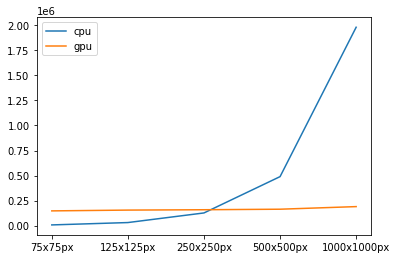

In [36]:
import matplotlib.pyplot as plt

cpu = [6927, 30480, 126522, 489303, 1981285];
gpu = [147106, 154961, 158522, 163784, 189801];
size = ['75x75px', '125x125px', '250x250px', '500x500px', '1000x1000px'];

fig, ax = plt.subplots()
ax.plot(size, cpu, label="cpu")
ax.plot(size, gpu, label="gpu")
ax.legend()

plt.show()

In [ ]:
Распараллелено вычисление окрестностей точки с использованием функций текстур (tex2D). Алгоритм параллельного вычисления
с использованием GPU в данном случае показывает высокую эффективность, особенно это становится заметно при размерах 
изображений от 500x500px. С учетом современных требований в качеству изображений прменение графических многопоточных
процессоров для их обработки и фильтрации становиться безальтернативным.